# Signifikanstestning

Innan vi ger en rekommendation så bör vi kontrollera att det rör sig om en statistiskt säkerställd skillnad och inte bara en slumpmässig variation.

Här tittar vi på hur man kan göra detta från en Jupyter notebook. Det första vi behöver göra är att importera ett antal Python-bibliotek som låter oss läsa in data från Google Analytics, samt enklare kunna hantera vår data. 


In [105]:
import sys
!{sys.executable} -m pip install requests --user

import pandas as pd 
import json
import requests

/home/ros/.local/lib/python2.7/site-packages/pip/_vendor/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
You should consider upgrading via the 'pip install --upgrade pip' command.


## Fishers exakta test

Har man väldigt lite data kan man använda sig av Fishers exakta test. 

Låt oss använda detta för att kolla om det är någon statistisk skillnad i bounce rate mellan besökare som kommer från sociala media och användare som kommer via referral.

I det här fallet är vi intresserade av att läsa in totalt antal sessions och totalt antal bounces för
Vi använder oss av Google Analytics Query Explorer för att välja ut den data vi vill läsa in:

https://ga-dev-tools.appspot.com/query-explorer/?ids=ga%3A130903410&start-date=30daysAgo&end-date=yesterday&metrics=ga%3Asessions%2Cga%3Abounces&dimensions=ga%3AchannelGrouping

Query explorer låter oss enkelt välja ut den data vi vill ha och längst ner på sidan hittar vi en länk till det API som används för att läsa ut data. Vi kan kopiera den länken och sedan göra ett anrop till denna med Python för att läsa in datan i vår notebook. Notera att länken endast fungerar i 60 min, vilket kan räcka för ett snabbt experiment, men vill man ha en mer permanent lösning bör man istället använda Google Analytics reporting API: https://developers.google.com/analytics/devguides/reporting/core/v4/quickstart/service-py 



In [106]:


r = requests.get('https://www.googleapis.com/analytics/v3/data/ga?ids=ga%3A130903410&start-date=30daysAgo&end-date=yesterday&metrics=ga%3Asessions%2Cga%3Abounces&dimensions=ga%3AchannelGrouping&access_token=ya29.ImCvBzxwlxnQYBJ5LPaFr5zhyAPGRRIKip0JDQ7MX4uW3E6sOEADyQhTdqERwV544zv8wsGRCMAb6O4bDHpIhd2VoKt-KUxqOHCMvXsVCshnFqvZlFTkFdDTUUichYZback')

data = r.json() # read data from a JSON format
df = pd.DataFrame(data['rows']) # turn data into a Pandas data frame
df = df.rename(columns={0: 'Channel', 1: 'Sessions', 2: 'Bounces'}) # giving the columns some proper titles
df['Sessions'] = df['Sessions'].astype(int) # formatting sessions as ints
df['Bounces'] = df['Bounces'].astype(int) # formatting users as ints

df # printing the first five rows


,Channel,Sessions,Bounces
0,(Other),137,39
1,Direct,315,94
2,Display,5,3
3,Email,146,62
4,Organic Search,146,60
5,Paid Search,2,1
6,Referral,466,169
7,Social,193,104


Vi har läst in data för våra kanaler och kan nu t.ex. beräkna antalet bounces och icke-bounces för användare som kommer från Social Media respektive Referral.

In [107]:

bounces = [df.values[7,2], df.values[6,2]]
non_bounces = [df.values[7,1]-df.values[7,2], df.values[6,1]-df.values[6,2]]


Vi kan nu använda Fishers exakta test för att kontrollera om skillnaden är signifikant. Ett p-värde < 0.05 innebär att vi har en signifikant skillnad.

In [108]:
import scipy.stats as stats

oddsratio, pvalue = stats.fisher_exact([bounces, non_bounces])

print (pvalue)

4.1473086347635335e-05


## T-test

En vanligare metod för att avgöra om vi har en statistiskt säkerställd skillnad mellan olika kanaler är att använda sig av ett t-test.

Här sätter vi upp en noll-hypotes med antagandet att bounce-raten är samma för besökare som kommer från social media och för besökare som kommer via en annan referral.

Vi hämtar bounce-rate för referral från:
https://ga-dev-tools.appspot.com/query-explorer/?ids=ga%3A130903410&start-date=2017-10-26&end-date=2017-11-02&metrics=ga%3AbounceRate&dimensions=ga%3Adate&filters=ga%3AchannelGrouping%3D%3DReferral

och bounce-rate för social från:

https://ga-dev-tools.appspot.com/query-explorer/?ids=ga%3A130903410&start-date=2017-10-26&end-date=2017-11-02&metrics=ga%3AbounceRate&dimensions=ga%3Adate&filters=ga%3AchannelGrouping%3D~(Social)

Koden nedan ser kanske komplicerad ut, men det är i princip samma kod som för inläsningen av GA data som vi använde för vårt Fisher test, bara att vi nu läser in två separata dataframes och slår ihop dessa.



In [109]:
r = requests.get('https://www.googleapis.com/analytics/v3/data/ga?ids=ga%3A130903410&start-date=2017-10-26&end-date=2017-11-02&metrics=ga%3AbounceRate&dimensions=ga%3Adate&filters=ga%3AchannelGrouping%3D%3DReferral&access_token=ya29.ImCvB316e-qxk20MajMUpwyng7EEarbUCImxEhOr0EPTN99m5EXEZvynd9WWTRKrP59N2VwuyH2aES8Con1bYKNoEs2JmkP13kXkAl9oCbvRo4xd2zJyutP6X0v3NL6GOVg')

data = r.json() # read data from a JSON format
df1 = pd.DataFrame(data['rows']) # turn data into a Pandas data frame
df1 = df1.rename(columns={0: 'Date', 1: 'Bounce rate referral'}) # giving the columns some proper titles
df1['Bounce rate referral'] = df1['Bounce rate referral'].astype(float) # formatting bounce rate as floats
df1['Date'] = pd.to_datetime(df1['Date'])

r = requests.get('https://www.googleapis.com/analytics/v3/data/ga?ids=ga%3A130903410&start-date=2017-10-26&end-date=2017-11-02&metrics=ga%3AbounceRate&dimensions=ga%3Adate&filters=ga%3AchannelGrouping%3D%3DSocial&access_token=ya29.ImCvB316e-qxk20MajMUpwyng7EEarbUCImxEhOr0EPTN99m5EXEZvynd9WWTRKrP59N2VwuyH2aES8Con1bYKNoEs2JmkP13kXkAl9oCbvRo4xd2zJyutP6X0v3NL6GOVg')

data = r.json() # read data from a JSON format
df2 = pd.DataFrame(data['rows']) # turn data into a Pandas data frame
df2 = df2.rename(columns={0: 'Date2', 1: 'Bounce rate social'}) # giving the columns some proper titles
df2['Bounce rate social'] = df2['Bounce rate social'].astype(float) # formatting bounce rate as floats
df2['Date2'] = pd.to_datetime(df2['Date2'])

df = pd.concat([df1, df2], axis=1, sort=False)

df



,Date,Bounce rate referral,Date2,Bounce rate social
0,2017-10-26,0.000000,2017-10-26,42.857143
1,2017-10-27,0.000000,2017-10-27,75.000000
2,2017-10-28,40.000000,2017-10-28,33.333333
3,2017-10-29,35.636364,2017-10-29,54.198473
4,2017-10-30,30.693069,2017-10-30,52.694611
5,2017-10-31,32.258065,2017-10-31,51.315789
6,2017-11-01,35.172414,2017-11-01,53.333333
7,2017-11-02,35.087719,2017-11-02,89.830508


Vi har nu läst in en tabell med bounce rate för kanalerna referral och social. Om vi vill kan vi även enkelt visualisera hur bounce raten för de olika kanalerna ändras över tiden.

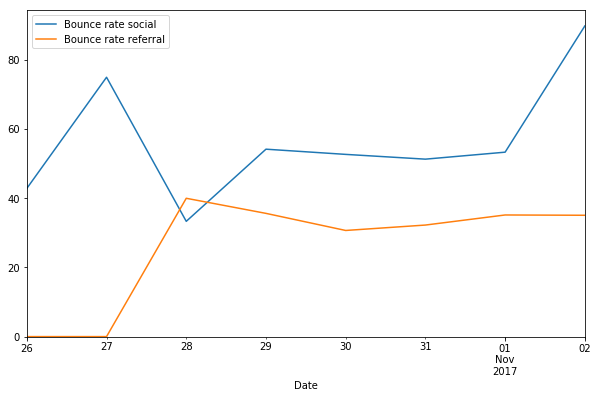

In [110]:
df.plot.line(x='Date', y=['Bounce rate social', 'Bounce rate referral'], ylim=[0,None], figsize=[10, 6])

Vi kan nu göra et parat t-test och verifiera att skillnaden är signifikant (p<0.05).

In [111]:
from scipy.stats import ttest_rel

ttest_rel(df.values[:,1], df.values[:,3])

Ttest_relResult(statistic=-3.3613346337176226, pvalue=0.012062294991340438)